In [1]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
import pickle
import glob
import seaborn as sns
from config import configuration
config = configuration()
config.request_password()

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


 ·············


In [22]:
gg = glob.glob('/local/scratch_2/jls/virac_classifier/binary/edr3_SJ_noalias/binary_t*.pkl')

gg = list(set(gg) - set(glob.glob('/local/scratch_2/jls/virac_classifier/binary/edr3_SJ_noalias/binary_*test*.pkl')))

colors = {'CONST':'k', 'DSCT':sns.color_palette()[0], 
          'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3],
          'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 
          'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
bins_class={}

groups = [['EW'],['EA/EB'],['RRab'],['RRc','RRd'],['Ell'],['CEP','T2CEP'],['MIRA','SRV','OSARG'],
         ['DSCT']]

with open('/local/scratch_2/jls/virac_classifier/binary/edr3_SJ_noalias/binary_training_set_0.pkl', 'rb') as f:
    binary = pickle.load(f)
for ss in groups:
    fltr = np.array([False])*len(binary.training_set)
    for ssg in ss:
        fltr |= (binary.training_set['detailed_var_class']==ssg)
    nn = np.count_nonzero(fltr)
    bincount = np.min([nn//20,50])
    bins_class[ss[0]] = np.nanpercentile(binary.training_set['ks_b_ivw_mean_mag'][
        fltr&(binary.training_set['class']==binary.training_set['var_class'])],
                                       np.linspace(0.5,99.5,bincount+1))

def loader(g, prob_thresh=0.65):
    print(g)
    with open(g, 'rb') as f:
        binary = pickle.load(f)
        if ~hasattr(binary, 'periodic_features'):
            binary.periodic_features=[]
        if ~hasattr(binary, 'no_upper_features'):
            binary.no_upper_features=[]
        binary.training_set = (binary.training_set[::-1][~binary.training_set['sourceid'][::-1].duplicated()]).reset_index(drop=True)
        
    totals = binary.training_set['detailed_var_class'].value_counts()
    total_const = binary.training_set['detailed_var_class'][binary.training_set['class']=='CONST'].value_counts()
    
    var_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&(binary.training_set['class']=='VAR')
                                                                      &(binary.training_set['prob']>prob_thresh)],
                              range=[11,17],bins=50)
    var_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='VAR')&((binary.training_set['class']=='CONST')
                                                                          |(binary.training_set['prob']<prob_thresh))],
                              range=[11,17],bins=50)
    const_const, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&((binary.training_set['class']=='CONST')
                                                                          |(binary.training_set['prob']<prob_thresh))],
                              range=[11,17],bins=50)
    const_var, b = np.histogram(binary.training_set['ks_b_ivw_mean_mag'][(binary.training_set['var_class']=='CONST')&(binary.training_set['class']=='VAR')
                                                                        &(binary.training_set['prob']>prob_thresh)],
                              range=[11,17],bins=50)
    mis_count={}
    all_count={}
    for ss in groups:
        fltr = np.array([False])*len(binary.training_set)
        for ssg in ss:
            fltr |= (binary.training_set['detailed_var_class']==ssg)
        mis_count[ss[0]],_=np.histogram(binary.training_set['ks_b_ivw_mean_mag'][
                                fltr&(binary.training_set['class']!=binary.training_set['var_class'])],
                                        bins=bins_class[ss[0]])
        all_count[ss[0]],_=np.histogram(binary.training_set['ks_b_ivw_mean_mag'][fltr],
                                        bins=bins_class[ss[0]])
        all_count[ss[0]]=np.float64(all_count[ss[0]])
        if ss=='CONST':
            all_count[ss][all_count[ss]<50]=np.nan
    
    return {'feature importance': binary.feature_importance, 
            'confusion matrix': binary.cm, 
            'classification report': binary.cr, 
            'total number per class': totals, 
            'total per class classified as const':total_const, 
            'magnitude bins':.5*(b[1:]+b[:-1]), 
            'variable correctly classified':var_var, 
            'variable misclassified':var_const, 
            'constant correctly classified':const_const, 
            'constant misclassified':const_var,
            'all detailed count equal bins': all_count,
            'misclassified detailed count equal bins': mis_count
           }

full_set = [loader(g) for g in gg]

/local/scratch_2/jls/virac_classifier/binary/edr3_SJ_noalias/binary_training_set_0.pkl


(11.5, 17.0)

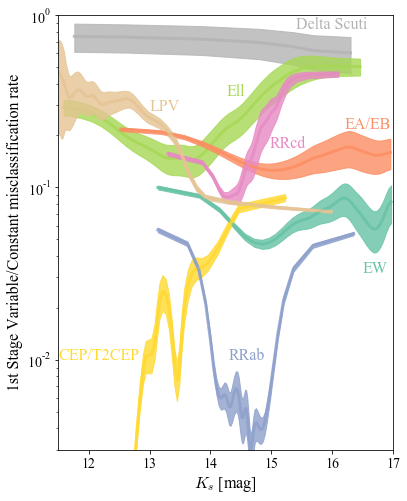

In [26]:
colors = {'CONST':'k', 'Delta Scuti':sns.color_palette()[0], 
          'EA/EB':sns.color_palette()[1], 'EW':sns.color_palette()[2], 'RRab':sns.color_palette()[3]
         , 'RRc':sns.color_palette()[4], 'OSARG':sns.color_palette()[5], 
          'Ell':'purple', 'RRd':'pink', 'CEP':'blue', 
          'MIRA':'red', 'SRV':'red', 'T2CEP':'blue'}
lbl = {'CONST':'k', 'DSCT':'Delta Scuti', 
          'EA/EB':'EA/EB', 'EW':'EW', 'RRab':'RRab'
         , 'RRc':'RRcd', 'OSARG':sns.color_palette()[5], 
          'Ell':'Ell', 'RRd':'pink', 'CEP':'CEP/T2CEP', 
          'MIRA':'LPV', 'SRV':'red', 'T2CEP':'blue'}
zorder = {'CONST':0, 'DSCT':-4, 
          'EA/EB':0, 'EW':0, 'RRab':1
         , 'RRc':0, 'OSARG':0, 
          'Ell':-2, 'RRd':0, 'CEP':0, 
          'MIRA':0, 'SRV':0, 'T2CEP':0}
from plotting_general import running_stat
plt.figure(figsize=[6.,8.])
scaling = lambda xx: xx #np.power((xx-11.)/(17-11.),3.)
from scipy.ndimage import gaussian_filter1d

xy = [[16.5,0.032],[16.2,0.22],[14.3,0.01], # EW, EA/EB, RRab
      [14.98,0.17],[14.26,0.34],[11.5,0.01], # RRc, Ell, CEP
      [13.0,0.28],[15.4,0.83]] # MIRA, DSCT
for jj,ss in enumerate(groups):
    ii = ss[0]
    x = scaling(.5*(bins_class[ii][1:]+bins_class[ii][:-1]))
    y=gaussian_filter1d(np.nanmedian([f['misclassified detailed count equal bins'][ii]/f['all detailed count equal bins'][ii] 
                               for f in full_set],axis=0),2.)
    z = gaussian_filter1d(np.nanmedian([f['all detailed count equal bins'][ii] for f in full_set],axis=0)[1:]/np.diff(x), 2.)
    z = np.concatenate([[z[0]],z])
    
    scll=0.01
    plt.plot(x, y,lw=3,
                     color=sns.color_palette('Set2')[jj],label=lbl[ii],alpha=0.8,zorder=zorder[ii]+1)
    plt.fill_between(x, y*(1-scll*z/np.nanmedian(z)*20), y*(1+scll*z/np.nanmedian(z)*20),
                     color=sns.color_palette('Set2')[jj],alpha=0.8,zorder=zorder[ii])
    
    plt.annotate(lbl[ii],xy=xy[jj],color=sns.color_palette('Set2')[jj],fontsize=16)
    
plt.ylim(3e-3,1.)
plt.semilogy()
plt.xlabel(r'$K_s$ [mag]')
# plt.xlim(16.,)
plt.ylabel(r'1st Stage Variable/Constant misclassification rate')
plt.xlim(11.5,17.)
plt.savefig('misclass.pdf', bbox_inches='tight')

In [37]:
const_CR = pd.DataFrame.from_dict([f['classification report']['CONST'] for f in full_set]).mean()
print(const_CR)
var_CR = pd.DataFrame.from_dict([f['classification report']['VAR'] for f in full_set]).mean()
print(var_CR)

f1-score         0.771423
precision        0.655073
recall           0.938030
support      95514.000000
dtype: float64
f1-score          0.930939
precision         0.983729
recall            0.883526
support      405036.000000
dtype: float64


In [36]:
CM=np.sum([f['confusion matrix'] for f in full_set],axis=0)/np.sum([f['confusion matrix'] for f in full_set],axis=(0,1))
print(CM)

[[0.65507308 0.01627087]
 [0.34492692 0.98372913]]


In [57]:
pd.set_option("display.precision", 3)

ks_eta                   0.069
ks_kurtosis              0.004
ks_mad                   0.035
ks_mad_over_error        0.073
ks_p100_p0               0.010
ks_p100_p0_over_error    0.004
ks_p75_p25               0.052
ks_p75_p25_over_error    0.063
ks_p84_p16               0.056
ks_p84_p16_over_error    0.043
ks_p95_p5                0.037
ks_p95_p5_over_error     0.017
ks_p99_p1                0.016
ks_p99_p1_over_error     0.006
ks_skew                  0.022
ks_stdev                 0.043
ks_stdev_over_error      0.011
ks_stetson_i             0.242
ks_stetson_j             0.119
ks_stetson_k             0.006
dtype: float64


Text(0.5, 0, 'Feature importance')

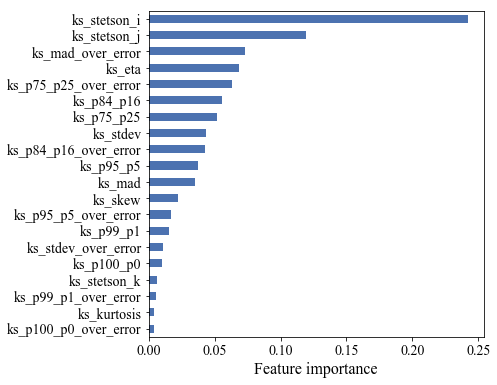

In [58]:
plt.figure(figsize=[6.,6.])
df=pd.DataFrame.from_dict([f['feature importance'] for f in full_set]).median()
print(df)
df.nsmallest(30).plot(kind='barh')
plt.xlabel('Feature importance')

In [24]:
np.unique(binary.training_set['detailed_var_class'].astype(str).values)

array(['CEP', 'CONST', 'DSCT', 'EA/EB', 'EW', 'Ell', 'MIRA', 'OSARG',
       'RRab', 'RRc', 'RRd', 'SRV', 'T2CEP', 'nan'], dtype=object)

In [28]:
np.count_nonzero(binary.training_set['detailed_var_class'].astype(str).values=='nan')

176

ks_eta                   0.072474
ks_kurtosis              0.011779
ks_mad                   0.050175
ks_mad_over_error        0.073684
ks_p100_p0               0.015602
ks_p100_p0_over_error    0.005995
ks_p75_p25               0.068779
ks_p75_p25_over_error    0.061511
ks_p84_p16               0.067240
ks_p84_p16_over_error    0.043576
ks_p95_p5                0.041504
ks_p95_p5_over_error     0.018917
ks_p99_p1                0.017382
ks_p99_p1_over_error     0.006871
ks_skew                  0.022735
ks_stdev                 0.045174
ks_stdev_over_error      0.013719
ks_stetson_i             0.239544
ks_stetson_j             0.116102
ks_stetson_k             0.007236
dtype: float64


Text(0.5, 0, 'Feature importance')

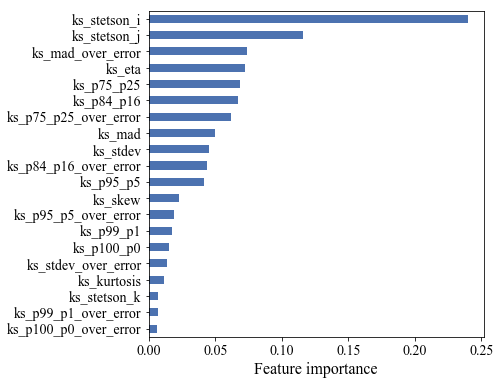

In [15]:
plt.figure(figsize=[6.,6.])
df=pd.DataFrame.from_dict([f['feature importance'] for f in full_set]).mean()
print(df)
df.nsmallest(30).plot(kind='barh')
plt.xlabel('Feature importance')

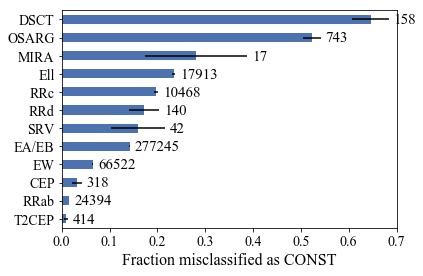

In [31]:
total_classes = pd.DataFrame.from_dict([f['total number per class'] for f in full_set])
misclassified = pd.DataFrame.from_dict([f['total per class classified as const'] for f in full_set])
rates = (misclassified/total_classes).mean().nsmallest(20)[:-1]
C=total_classes.mean().to_dict()
Xerr = [np.sqrt(R*(1-R)/C[d]) for R,d in zip(rates.values,rates.keys())]
rates.plot(kind='barh', xerr=Xerr)
plt.xlabel(r'Fraction misclassified as CONST')
plt.xlim(0.,0.7)
[plt.annotate('%i'%C[c],(d+0.01+x,i-0.25),fontsize=15) 
 for i,(d,c,x) in enumerate(zip(rates.values,rates.keys(),Xerr))];